## Purpose of script:
#### Basic tutorial on using Structural Causal Models (SCMs) to infer causal relationships
#### This script references code from:
#### https://towardsdatascience.com/causal-inference-962ae97cefda

In [12]:
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image, display
import econml
import dowhy
from dowhy import CausalModel
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pickle.load( open( "../Datasets/df_causal_inference.p", "rb" ) )
print(df.shape)
df.head(2)

(29170, 3)


,age,hasGraduateDegree,greaterThan50k
0,39,False,False
1,50,False,False


In [7]:
df.age.describe()

count    29170.000000
mean        38.655674
std         13.722408
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [5]:
df.hasGraduateDegree.value_counts()

False    27643
True      1527
Name: hasGraduateDegree, dtype: Int64

In [6]:
df.greaterThan50k.value_counts()

False    21999
True      7171
Name: greaterThan50k, dtype: Int64

In [8]:
model=CausalModel(
        data = df,
        treatment= "hasGraduateDegree",
        outcome= "greaterThan50k",
        common_causes="age",
        )

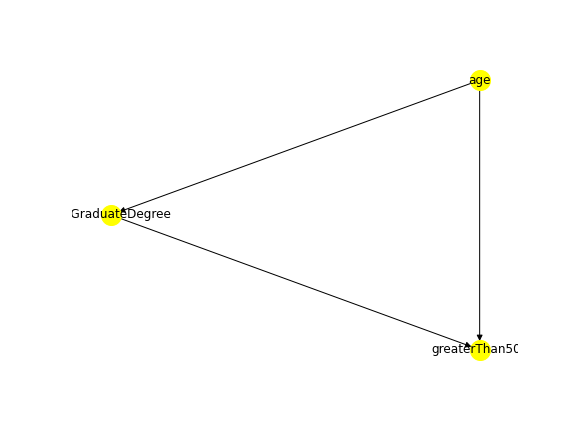

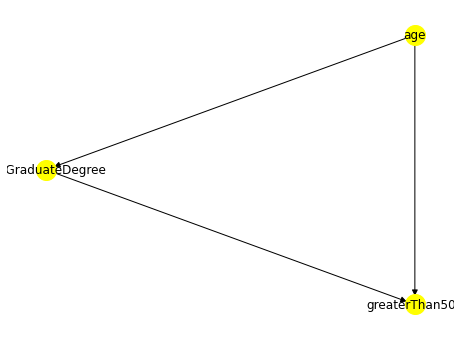

In [10]:
model.view_model()
display(Image(filename="causal_model.png"))

In [11]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [13]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

metalearner_estimate = model.estimate_effect(identified_estimand_experiment,
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.20255666286305837
Effect estimates: [[ 0.30689318]
 [ 0.20860197]
 [ 0.36346222]
 ...
 [ 0.17354447]
 [-0.01455916]
 [ 0.20258306]]



(array([  74.,  113.,  973., 5981., 2930., 5472., 8443., 2625., 2522.,
          37.]),
 array([-0.2908824 , -0.20123409, -0.11158578, -0.02193747,  0.06771084,
         0.15735915,  0.24700746,  0.33665576,  0.42630407,  0.51595238,
         0.60560069]),
 <BarContainer object of 10 artists>)

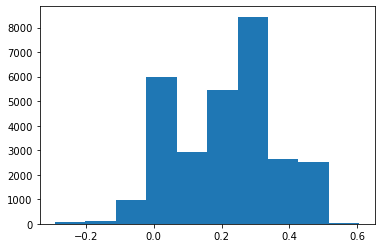

In [14]:
# print histogram of causal effects for each sample
plt.hist(metalearner_estimate.cate_estimates)